In [1]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
import numpy as np

import warnings
warnings.filterwarnings("ignore")


bottle_filter = 512
final_filter = 16
num_classes = 1
output_channels = 1

In [2]:
def mlp(x, cf):
    x = Dense(cf["mlp_dim"], activation='gelu')(x)
    x = Dropout(cf["dropout_rate"])(x)
    x = Dense(cf["hidden_dim"])(x)
    x = Dropout(cf["dropout_rate"])(x)

    return x

In [3]:
def transformer_encoder(x, cf):
    skip_1 = x
    x =  LayerNormalization()(x)
    x = Conv1D()

    x =  MultiHeadAttention(num_heads = cf["num_heads"],
                            key_dim = cf["hidden_dim"]
                            )(x,x)
    x =  Add()([x, skip_1])

    skip_2 = x
    x =  LayerNormalization()(x)
    x =  mlp(x, cf)
    x =  Add()([x, skip_2])

    return x


In [4]:
#this defines the convolutions process involved in the decoder
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    #next block
    x = Conv2D(num_filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

In [5]:
# create a number of decoder blocks
def decoder_block(inputs, skip_features, num_filters):

    #first layer of each decoder block is a 2D-Conv transpose layer of shape 2,2
    x = Conv2DTranspose(num_filters, (2,2), strides=2, padding='same')(inputs)
    x = Concatenate()([x,skip_features])
    x = conv_block(x, num_filters)
    return x

In [6]:
def ResNet50ViT(cf):
    #defining the input layer
    inputs =  Input((cf["image_size"],cf["image_size"], cf["num_channels"]))
    #print(inputs.shape)
    #pretrained resnet 50

    resnet50 =  ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
    #freeze the base resnet layer
    resnet50.trainable = False
    output = resnet50.get_layer('conv4_block4_out').output  #(None, 16, 16, 1024)
    #print(output.shape)
    #print(resnet50.summary())

    # definng the skip connections for the decoder block to be used later on
    s1 = resnet50.get_layer('conv1_relu').output    #256
    s2 = resnet50.get_layer('conv2_block3_out').output  #128
    s3 = resnet50.get_layer('conv3_block4_out').output  #64

    #creating patch embeddings for the transformer block
    patch_embed = Conv2D(cf["hidden_dim"],
                         kernel_size = cf["patch_size"],
                         padding = 'same'
                         )(output)
    
    #print(patch_embed.shape)
    _, h, w, f = patch_embed.shape
    patch_embed = Reshape((h*w,f))(patch_embed)
    #print(patch_embed.shape)

    #position embedings
    positions = tf.range(start=0, limit=cf["num_patches"], delta=1)
    #print(positions)

    pos_embed = Embedding(input_dim = cf ["num_patches"], output_dim = cf["hidden_dim"])(positions)
    #print(pos_ebedding.shape)

    #path + position embedding
    embed = patch_embed + pos_embed
    #print(embed.shape)

    #class embedding has been skipped for this implementation
    x = embed

    #Adding the transformer encoder
    #as the transformer encoder is repeated for 12 times

    for _ in range(cf["num_layers"]):
        x = transformer_encoder(x,cf)

    #print(x.shape)
    # reshaping the output of the transformer encoder
    _, hw, f = patch_embed.shape
    x =  Reshape((hw//cf["patch_size"],hw//cf["patch_size"],f))(x)

    # the bottleneck convolution layer
    x = Conv2D(bottle_filter, 3, padding='same')(x)   # this gives the starting path of the upsampling layers
    #print(x.shape)


    #creating a decoder block
    d1 =  decoder_block(x, s3, 256)        #64
    d2 =  decoder_block(d1, s2, 128)        #128
    d3 =  decoder_block(d2, s1, 64)        #256
    #print(d3.shape)

    #the 2nd last layer is an upsampling layer with a 16 filter number, the input for the upsampling

    x = Conv2DTranspose(final_filter, (2,2), strides=2, padding='same')(d3)

    # A segmentation head is then attached to the final layer to generate the mask
    outputs = Conv2D(output_channels, 1, padding='same', activation='sigmoid')(x)

    #building the final model
    model = model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

    return model

    #print(outputs.shape)
    
    

In [7]:
if __name__ == '__main__':
    config = {}
    config["num_layers"] = 12
    config["hidden_dim"] = 768 #changed from 768
    config["mlp_dim"] = 3072
    config["num_heads"] = 12
    config["dropout_rate"] = 0.1

    config["image_size"] = 256
    config["patch_size"] = 16
    config["num_patches"] = int(config["image_size"]**2 / config["patch_size"]**2)
    config["num_channels"] = 3
    config["num_classes"] = 1   #changed from 10

    model = ResNet50ViT(config)
    model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

Testing on a data

Resizing training images and masks


100%|██████████| 670/670 [02:15<00:00,  4.96it/s]


Resizing test images


100%|██████████| 65/65 [00:01<00:00, 53.66it/s]


Done!


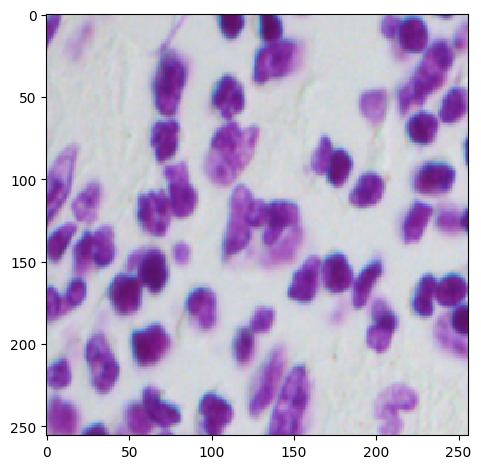

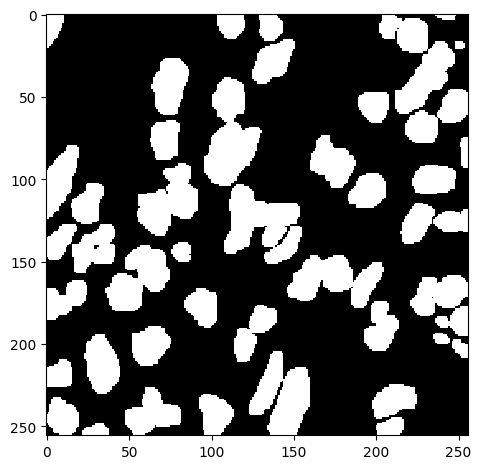

In [8]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import random
import numpy as np
from skimage.io import imread, imshow
from skimage.transform import resize

seed = 42
np.random.seed = seed

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

TRAIN_PATH = 'data-science-bowl-2018/stage1_train/'
TEST_PATH = 'data-science-bowl-2018/stage1_test/'

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)

print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
            
    Y_train[n] = mask   

# test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

In [9]:
X_train2 = X_train[:100]
Y_train2 = Y_train[:100]

In [17]:
sgd = tf.keras.optimizers.SGD(
    learning_rate=0.01,
    momentum=0.9,
    name="SGD",
    decay = 0.00001
    )
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
results = model.fit(X_train2, Y_train2, validation_split=0.1, batch_size=32, epochs=15)

Epoch 1/15
3/3 [==============================] - 268s 86s/step - loss: 0.3899 - accuracy: 0.8570 - val_loss: 0.4574 - val_accuracy: 0.8235
Epoch 2/15
3/3 [==============================] - 249s 80s/step - loss: 0.3800 - accuracy: 0.8589 - val_loss: 0.4543 - val_accuracy: 0.8240
Epoch 3/15
3/3 [==============================] - 240s 78s/step - loss: 0.3627 - accuracy: 0.8625 - val_loss: 0.4499 - val_accuracy: 0.8249
Epoch 4/15
3/3 [==============================] - 238s 79s/step - loss: 0.3417 - accuracy: 0.8659 - val_loss: 0.4441 - val_accuracy: 0.8266
Epoch 5/15
3/3 [==============================] - 240s 79s/step - loss: 0.3237 - accuracy: 0.8702 - val_loss: 0.4386 - val_accuracy: 0.8276
Epoch 6/15
3/3 [==============================] - 239s 78s/step - loss: 0.2996 - accuracy: 0.8779 - val_loss: 0.4321 - val_accuracy: 0.8289
Epoch 7/15
3/3 [==============================] - 241s 79s/step - loss: 0.2822 - accuracy: 0.8842 - val_loss: 0.4241 - val_accuracy: 0.8321
Epoch 8/15
3/3 [====

In [18]:
idx = random.randint(0, len(X_train))


#preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
#preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

 
#preds_train_t = (preds_train > 0.5).astype(np.uint8)
#preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)



3/3 [==============================] - 54s 13s/step


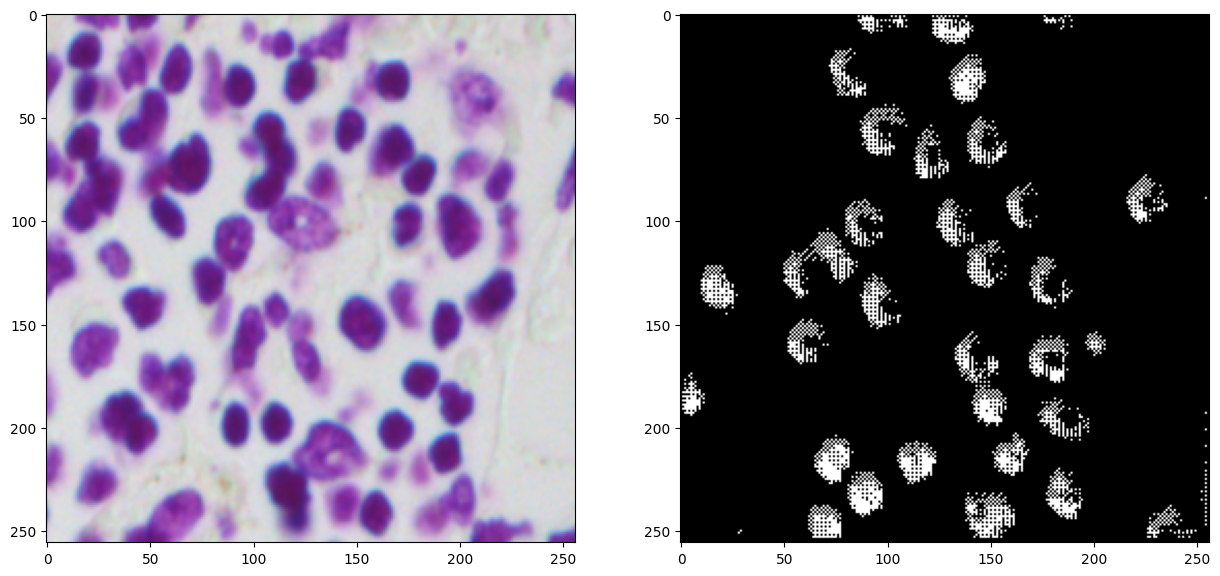

In [34]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_test_t))
fig, (ax1, ax2)= plt.subplots(1,2)
fig.set_size_inches(15,30)
ax1.imshow(X_train[int(X_train.shape[0]*0.9):][ix])
ax2.imshow(np.squeeze(preds_test_t[ix]), alpha=1, cmap='gray')
plt.show()